In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from statannot import add_stat_annotation
matplotlib.rcParams['pdf.fonttype'] = 42

### dic interaction
dic_interaction = {}
with open("/home/mouren/Data/revisions/specificity/robust_associations_exons_genes.txt") as file:
    for line in file:      
        if line.strip().split()[0] not in dic_interaction:
            dic_interaction[line.strip().split()[0]] = [line.strip().split()[1]]
        else:
            dic_interaction[line.strip().split()[0]].append(line.strip().split()[1])

### Load exon-to-biotype map
tmp_dic = {}
with open("/home/mouren/Data/revisions/specificity/exons_BioGtex_majority_bilan.tsv") as file:
    for line in file:
        parts = line.strip().split()
        if parts[3] == "TRUE":
            tissue = parts[4]
            ee = parts[0]
            tmp_dic.setdefault(tissue, []).append(ee)

### ee_spec_wth_target
ee_to_plot_dic = {}
for key,val in tmp_dic.items():
    ee_to_plot_dic[key] = []
    for ee in val:
        if ee in dic_interaction:
            for target in dic_interaction[ee]:
                ee_to_plot_dic[key].append(target) 

### Load GTEx median TPM data
df_tmp = pd.read_csv('/home/mouren/Data/revisions/specificity/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct', sep='\t', header=0)
df_tmp = df_tmp[~df_tmp['Name'].str.contains("PAR_Y")]
df_tmp['Name_split'] = df_tmp['Name'].str.split('.').str.get(0)

# Now we can remove thoses two columns
column_exons_id = df_tmp.pop('Name')
column_gene_id = df_tmp.pop('Description')
column_gene_id2 = df_tmp.pop('Name_split')

## Normalize data
def normalize_row(row):
    row_mean = row.mean()
    row_std = row.std()
    row_normalized = (row - row_mean) / (row_std+1e-5) #to avoid dividing by zero
    #row_normalized = row/row_mean
    return row_normalized

df_gtex = df_tmp.apply(normalize_row, axis=1)
df_gtex["Gene"] = column_gene_id2

### Load transcript-to-gene mapping
dic_transcript_gene = {}
with open("/home/mouren/Data/revisions/specificity/list_transript_gene_id_gencodeV41_all_proteincoding.tsv") as file:
    for line in file:
        tx, gene = line.strip().split()[:2]
        dic_transcript_gene[tx] = gene.split(".")[0]

### Load GTEx simplified tissue type mapping
dic_gtex_simple = {}
with open("/home/mouren/Data/revisions/specificity/gTEXBiotypesFull_Simplified.csv") as file:
    for line in file:
        parts = line.strip().split("\t")
        if len(parts) >= 2:
            dic_gtex_simple[parts[0]] = parts[1]

# Reverse mapping: get all unique simplified tissue types
tissue_groups = set(dic_gtex_simple.values())

# Prepare division by number of gtex tissue mapped 
dic_division = {}
for val in dic_gtex_simple.values():
    if val not in dic_division:
        dic_division[val] = 1
    else:
        dic_division[val] += 1

### Main result dictionary
res_by_signature = {}

### Process all exon biotype groups
for signature, ee_list in ee_to_plot_dic.items():
    res_by_signature[signature] = {}
    for ee in ee_list:
        filtered_row = df_gtex[df_gtex['Gene'] == ee]
        if filtered_row.empty:
            continue
        entry = {group: None for group in tissue_groups}
        for col in filtered_row.columns:
            if col == "Gene":
                continue
            tissue_group = dic_gtex_simple.get(col)
            if tissue_group:
                value = filtered_row[col].values[0]
                if entry[tissue_group] is None:
                    entry[tissue_group] = value
                else:
                    entry[tissue_group] += value
        # Normalize
        for i,j in entry.items():
            entry[i] = j/dic_division[i]
        res_by_signature[signature][ee] = entry


In [10]:
# Flatten into plotting DataFrame
dataf = []
all_signatures = list(res_by_signature.keys())
plot_tissues = ["Endocrine","Reproductive_M", "Respiratory"] # You can expand this as needed

for signature in all_signatures:
    for tissue in plot_tissues:
    #for tissue in tissue_groups:
        values = [
            entry.get(tissue)
            for entry in res_by_signature[signature].values()
            if tissue in entry and entry[tissue] is not None
        ]
        dataf.append({"Signature": signature, "Tissue": tissue, "TPM": values})

/tmp/ipykernel_1273172/3985074160.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df_exploded.groupby(['Signature', 'Tissue']).apply(remove_outliers_iqr).reset_index(drop=True)
/tmp/ipykernel_1273172/3985074160.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = df_no_outliers.groupby(['Signature', 'Tissue'])['TPM'].count().reset_index()


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Reproductive_M_Reproductive_M v.s. Reproductive_M_Respiratory: Mann-Whitney-Wilcoxon test two-sided, P_val=4.938e-03 U_stat=2.485e+03
Respiratory_Reproductive_M v.s. Respiratory_Respiratory: Mann-Whitney-Wilcoxon test two-sided, P_val=1.797e-01 U_stat=2.700e+01
Endocrine_Endocrine v.s. Endocrine_Reproductive_M: Mann-Whitney-Wilcoxon test two-sided, P_val=4.996e-02 U_stat=4.760e+02
Reproductive_M_Endocrine v.s. Reproductive_M_Reproductive_M: Mann-Whitney-Wilcoxon test two-sided, P_val=2.184e-03 U_stat=1.332e+03
Respiratory_Endocrine v.s. Respiratory_Respiratory: Mann-Whitney-Wilcoxon test two-sided, P_val=1.014e-01 U_stat=3.300e+01
Endocrine_Endocrine v.s. Endocrine_Respiratory: Mann-Whitney-Wilcoxon test two-sided, P_val=1.451e-01 U_stat=4.470e+02


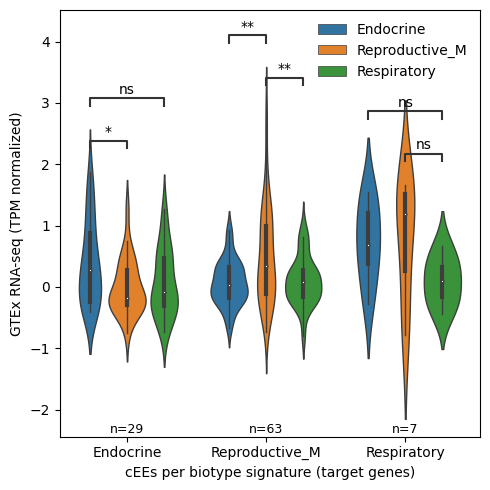

In [8]:
df = pd.DataFrame(dataf)
df_exploded = df.explode('TPM')
df_exploded['TPM'] = pd.to_numeric(df_exploded['TPM'])

# Optional: limit to selected signature/tissue pairs
df_exploded = df_exploded[df_exploded["Tissue"].isin(plot_tissues)]
df_exploded = df_exploded[df_exploded["Signature"].isin(plot_tissues)]
#df_exploded = df_exploded[df_exploded["Tissue"].isin(tissue_groups)]

def remove_outliers_iqr(group):
    Q1 = group['TPM'].quantile(0.25)
    Q3 = group['TPM'].quantile(0.75)
    IQR = Q3 - Q1
    return group[(group['TPM'] >= Q1 - 1.5 * IQR) & (group['TPM'] <= Q3 + 1.5 * IQR)]

df_no_outliers = df_exploded.groupby(['Signature', 'Tissue']).apply(remove_outliers_iqr).reset_index(drop=True)
df_no_outliers['Tissue'] = pd.Categorical(df_no_outliers['Tissue'], categories=plot_tissues, ordered=True)
#df_no_outliers['Tissue'] = pd.Categorical(df_no_outliers['Tissue'], categories=tissue_groups, ordered=True)

plt.figure(figsize=(5, 5))
ax = sns.violinplot(data=df_no_outliers, x="Signature", y="TPM", hue="Tissue",
                    order=sorted(df_no_outliers["Signature"].unique()),
                    flierprops={"marker": "o", 'markersize': 1}, linewidth=1)

### Add N
group_counts = df_no_outliers.groupby(['Signature', 'Tissue'])['TPM'].count().reset_index()
group_counts.columns = ['Signature', 'Tissue', 'N']
center_index = len(plot_tissues) // 2  # index of the center tissue (e.g., 1 if 3 tissues)

for i, sig in enumerate(plot_tissues):  # Signature is on x-axis
    sig_counts = group_counts[group_counts['Signature'] == sig]

    if not sig_counts.empty:
        max_row = sig_counts.loc[sig_counts['N'].idxmax()]
        count = max_row['N']

        x = i
        offset = center_index * 0.2 - 0.2  # fixed offset to center tissue position

        ax.text(x + offset,
                df_no_outliers['TPM'].min() - 1.6,  # adjust vertically as needed
                f'n={count}', ha='center', va='bottom', fontsize=9, color='black')

# Stats annotation
box_pairs = []
for sig in df_no_outliers["Signature"].unique():
    for i in range(len(plot_tissues)):
        for j in range(i+1, len(plot_tissues)):
            box_pairs.append(((sig, plot_tissues[i]), (sig, plot_tissues[j])))

valid_box_pairs = [
    (("Endocrine", "Endocrine"), ("Endocrine", "Reproductive_M")),
    (("Endocrine", "Endocrine"), ("Endocrine", "Respiratory")),
    (("Reproductive_M", "Reproductive_M"), ("Reproductive_M", "Endocrine")),
    (("Reproductive_M", "Reproductive_M"), ("Reproductive_M", "Respiratory")),
    (("Respiratory", "Respiratory"), ("Respiratory", "Endocrine")),
    (("Respiratory", "Respiratory"), ("Respiratory", "Reproductive_M")),
]

add_stat_annotation(ax, data=df_no_outliers, x="Signature", y="TPM", hue="Tissue",
                    order=sorted(df_no_outliers["Signature"].unique()), box_pairs=valid_box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=1, comparisons_correction=None)


ax.set_ylabel("GTEx RNA-seq (TPM normalized)")
ax.set_xlabel("cEEs per biotype signature (target genes)")
plt.legend(frameon=False, title=None)
plt.tight_layout()


plt.savefig("/home/mouren/Images/tls1/revisions/rev_1_pt4_violin_target.pdf", format="pdf", bbox_inches="tight", dpi=450)
plt.savefig("/home/mouren/Images/tls1/revisions/rev_1_pt4_violin_target.png", format="png", bbox_inches="tight", dpi=450)

plt.show()
